## 1. Brownian Motion

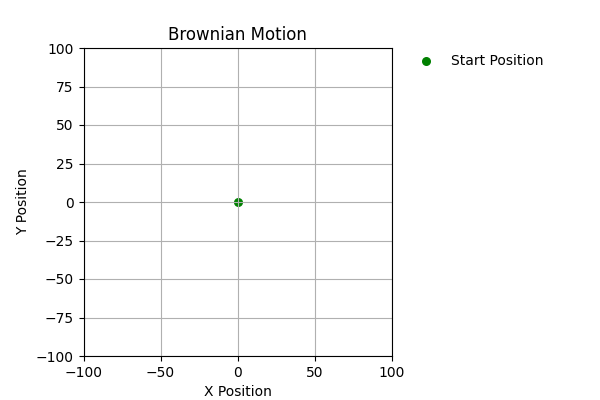

In [1]:
from ipywidgets import Button, IntSlider, VBox, HBox, Output, Layout
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from matplotlib.colors import to_hex
%matplotlib widget
plt.close('all')
output = Output()

# Global state management
simulations = {}
COLORS = plt.cm.tab10.colors

# Create figure and axes once
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(right=4/6)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect('equal')
ax.set_title("Brownian Motion")
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.grid(True)
ax.scatter(0, 0, c='green', s=30, label='Start Position')
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Position outside right
    borderaxespad=0.,
    frameon=False
)


with output:
    display(fig)

def run_simulation(D, steps):
    # Create unique simulation ID
    run = 1
    sim_id = f"D{D}_S{steps}_R{run}"
    
    # Generate new simulation data if not exists
    while sim_id in simulations:
        run += 1
        sim_id = f"D{D}_S{steps}_R{run}"
        
    step_std = np.sqrt(2 * D)
    x, y = np.zeros(steps), np.zeros(steps)
    
    # Store in simulations dict
    simulations[sim_id] = {
        'x': x,
        'y': y,
        'color': to_hex(COLORS[len(simulations) % len(COLORS)]),
        'label': f"D={D}, R#{run}",
        'complete': False
    }
    calculate_background(sim_id, step_std, steps)
    
    # Animate if it's the first simulation
    if len(simulations) == 1:
        animate_simulation(sim_id)
    
    # Update plot after simulation is complete
    update_plot()


def animate_simulation(sim_id):
    sim = simulations[sim_id]
    x = sim['x']
    y = sim['y']
    
    # Create animation objects
    sim['line'], = ax.plot([], [], color=sim['color'], alpha=1)
    sim['marker'] = ax.scatter([], [], color=sim['color'], s=30, alpha=1)
    
    with output:
        for t in range(1, len(x)):
            sim['line'].set_data(x[:t+1], y[:t+1])
            sim['marker'].set_offsets([[x[t], y[t]]])
            fig.canvas.draw()
            time.sleep(0.002)
        
        # Clean up marker
        # sim['marker'].remove()
        # sim['marker'] = None
        ax.legend(handles=[
            *ax.get_legend_handles_labels()[0],
            plt.Line2D([0], [0], color=sim['color'], label=sim['label'])
        ])
        fig.canvas.draw()
        

def calculate_background(sim_id, step_std, steps):
    sim = simulations[sim_id]
    # Calculate full path without animation
    for t in range(1, steps):
        dx, dy = np.random.normal(0, step_std, 2)
        sim['x'][t] = sim['x'][t-1] + dx
        sim['y'][t] = sim['y'][t-1] + dy
    sim['complete'] = True

def update_plot():
    with output:
        clear_output(wait=True)
        ax.clear()
        # Redraw canvas settings
        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 100)
        ax.set_aspect('equal')
        ax.set_title("Brownian Motion")
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True)
        ax.scatter(0, 0, c='green', s=30, label='Start Position')

        
        # Add simulation paths
        for sim_id, data in simulations.items():
            if data['complete']:
                ax.plot(data['x'], data['y'], color=data['color'], 
                        label=data['label'], alpha=1)
                ax.scatter(data['x'][-1], data['y'][-1], color=data['color'], s=30, alpha=1)

        # Create legend outside on right
        ax.legend(
            loc='upper left',
            bbox_to_anchor=(1.05, 1),  # Position outside right
            borderaxespad=0.,
            frameon=False
        )

# Create widgets
start_btn = Button(description="▶ Start Simulation", button_style='success')
reset_btn = Button(description="🔄 Reset", button_style='warning')

D_slider = IntSlider(min=1, max=10, value=1, description='Diffusion Coeff:', style={'description_width': '100px'},layout=Layout(width='400px'))
steps_slider = IntSlider(min=10, max=500, value=100, description='Time(Steps):', style={'description_width': '100px'},layout=Layout(width='400px'))

def on_start(b):
    run_simulation(2**(D_slider.value), steps_slider.value)

def on_reset(b):
    global simulations  # Important to access the global variable

    ax.clear()
    # Redraw canvas settings
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_aspect('equal')
    ax.set_title("Brownian Motion")
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True)
    ax.scatter(0, 0, c='green', s=30, label='Start Position')
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(1.05, 1),  # Position outside right
        borderaxespad=0.,
        frameon=False
    )

    simulations = {}

start_btn.on_click(on_start)
reset_btn.on_click(on_reset)

# Create UI
ui = VBox([
    VBox([D_slider, steps_slider]),
    HBox([start_btn, reset_btn])
])

# Initial display
with output:
    display(fig)
display(ui)


## 2. Einstein's theory

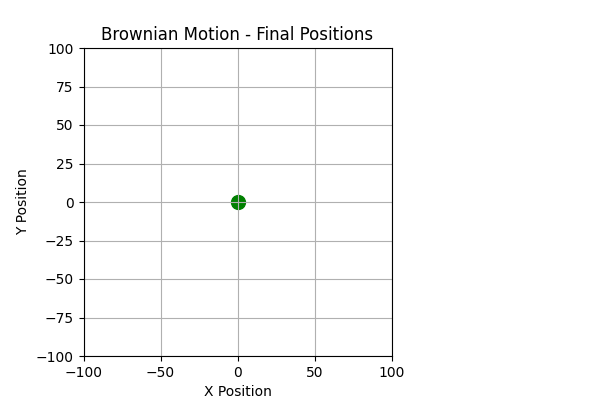

In [2]:
from ipywidgets import Button, IntSlider, VBox, HBox, Output, Layout
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from matplotlib.collections import CircleCollection
%matplotlib widget

output = Output()

# Global state management
all_x = np.array([])
all_y = np.array([])
collection = None
stop_simulation = False

# Create figure and axes once
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(right=4/6)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect('equal')
ax.set_title("Brownian Motion - Final Positions")
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.grid(True)
ax.scatter(0, 0, c='green', s=100, label='Start Position')


with output:
    display(fig)

def calculate_position(D, steps):
    """Calculate final position without storing path"""
    x, y = 0, 0
    step_std = np.sqrt(2 * D)
    for _ in range(steps):
        if stop_simulation:
            return None
        dx, dy = np.random.normal(0, step_std, 2)
        x += dx
        y += dy
    return x, y

def run_simulations(D, steps, N):
    global all_x, all_y, stop_simulation
    
    # Reset state
    all_x = np.array([])
    all_y = np.array([])
    stop_simulation = False
    update_batch_size = 1
    max_batch_size = 1024
    points_buffer = []
    
    for i in range(N):
        if stop_simulation:
            break
            
        # Calculate position
        result = calculate_position(D, steps)
        if result is None:
            break
            
        # Add to buffer
        points_buffer.append(result)
        
        # Update plot in batches
        if len(points_buffer) >= update_batch_size:
            # Convert buffer to arrays
            new_x = np.array([p[0] for p in points_buffer])
            new_y = np.array([p[1] for p in points_buffer])
            
            # Update global arrays
            all_x = np.concatenate([all_x, new_x])
            all_y = np.concatenate([all_y, new_y])

            # Update collection
            with output:
                ax.clear()
                ax.set_xlim(-100, 100)
                ax.set_ylim(-100, 100)
                ax.set_aspect('equal')
                ax.set_title(f"{len(all_x)} Samples")
                ax.set_xlabel('X Position')
                ax.set_ylabel('Y Position')
                ax.grid(True)
                ax.scatter(all_x, all_y, color='r', edgecolor='none', alpha=0.03)
                fig.canvas.draw()
            
            # Reset buffer and increase batch size
            points_buffer = []
            update_batch_size = min(max_batch_size, update_batch_size * 2)
        
        # Small delay to keep UI responsive
        time.sleep(0.001)
    
    # Add any remaining points
    if points_buffer and not stop_simulation:
        new_x = np.array([p[0] for p in points_buffer])
        new_y = np.array([p[1] for p in points_buffer])
        all_x = np.concatenate([all_x, new_x])
        all_y = np.concatenate([all_y, new_y])
        with output:
            ax.clear()
            ax.set_xlim(-100, 100)
            ax.set_ylim(-100, 100)
            ax.set_aspect('equal')
            ax.set_title(f"{len(all_x)} Samples")
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.grid(True)
            ax.scatter(all_x, all_y, color='r', edgecolor='none', alpha=0.03)
            fig.canvas.draw()

# Widgets
N_slider = IntSlider(min=1000, max=10000, value=5000, description='Simulations:', 
                    style={'description_width': '100px'}, layout=Layout(width='400px'))
D_slider = IntSlider(min=1, max=10, value=1, description='Diffusion Coeff:', 
                    style={'description_width': '100px'}, layout=Layout(width='400px'))
steps_slider = IntSlider(min=1, max=100, value=10, description='Time(Steps):', 
                        style={'description_width': '100px'}, layout=Layout(width='400px'))

start_btn = Button(description="▶ Start", button_style='success')
stop_btn = Button(description="⏹ Stop", button_style='danger')
reset_btn = Button(description="🔄 Reset", button_style='warning')

def on_start(b):
    run_simulations(
        2 ** D_slider.value,
        steps_slider.value,
        N_slider.value
    )

def on_stop(b):
    global stop_simulation
    stop_simulation = True

def on_reset(b):
    global all_x, all_y
    all_x = np.array([])
    all_y = np.array([])
    with output:
        collection.set_offsets(np.empty((0, 2)))
        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 100)
        fig.canvas.draw()

start_btn.on_click(on_start)
stop_btn.on_click(on_stop)
reset_btn.on_click(on_reset)

ui = VBox([
    VBox([N_slider, D_slider, steps_slider]),
    HBox([start_btn, stop_btn, reset_btn]),
])

display(ui)

## 3. Solution for Einstein's theory

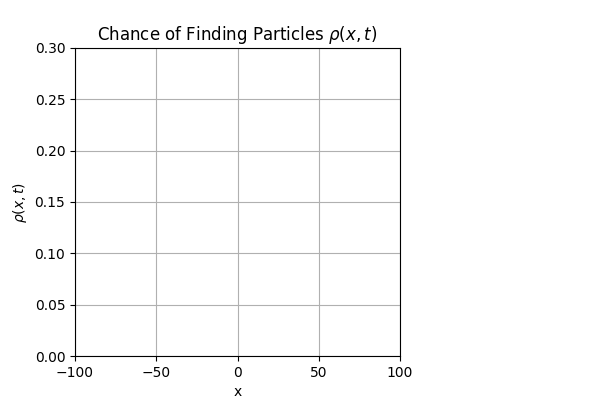

In [3]:
from ipywidgets import Button, IntSlider, VBox, HBox, Output, Layout

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import to_hex

# Use the interactive widget backend
%matplotlib widget
plt.close('all')
output = Output()

# Global state management
simulations = {}
COLORS = plt.cm.tab10.colors

# Create figure and axes once
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(right=4/6)
ax.set_xlim(-100, 100)
# Set an appropriate y-range; for example, for D=1, t=1, maximum at x=0 is 1/sqrt(4*pi) ~ 0.28
ax.set_ylim(0, 0.3)
ax.set_title(r"Chance of Finding Particles $\rho(x, t)$")
ax.set_xlabel('x')
ax.set_ylabel(r'$\rho(x,t)$')
ax.grid(True)

with output:
    display(fig)

def run_simulation(D, t):
    # Create unique simulation ID
    sim_id = f"D{D}_t{t}"
    if sim_id not in simulations:        
        # Generate x values over a fixed range
        x = np.linspace(-100, 100, 1000)
        # Compute the diffusion solution
        rho = 1 / np.sqrt(4 * np.pi * D * t) * np.exp(-x**2 / (4 * D * t))
        
        # Store simulation data
        simulations[sim_id] = {
            'x': x,
            'rho': rho,
            'color': to_hex(COLORS[len(simulations) % len(COLORS)]),
            'label': f"D={D}, t={t}"
        }
        update_plot()

def update_plot():
    with output:
        clear_output(wait=True)
        ax.clear()
        ax.set_xlim(-100, 100)
        ax.set_ylim(0, 0.3)
        ax.set_title(r"Chance of Finding Particles $\rho(x, t)$")
        ax.set_xlabel('x')
        ax.set_ylabel(r'$\rho(x,t)$')
        ax.grid(True)
        
        # Plot each simulation's curve
        for sim_id, data in simulations.items():
            ax.plot(data['x'], data['rho'], color=data['color'], label=data['label'])
        
        if simulations:
            ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)
        display(fig)

def on_reset(b):
    global simulations
    simulations = {}
    update_plot()

# Create widgets
start_btn = Button(description="▶ Run", button_style='success')
reset_btn = Button(description="🔄 Reset", button_style='warning')

D_slider = IntSlider(min=1, max=10, value=1, description='Diffusion Coeff:', 
                     style={'description_width': '120px'}, layout=Layout(width='400px'))
t_slider = IntSlider(min=1, max=100, value=1, description='Time:', 
                     style={'description_width': '120px'}, layout=Layout(width='400px'))

start_btn.on_click(lambda b: run_simulation(D_slider.value, t_slider.value))
reset_btn.on_click(on_reset)

ui = VBox([
    VBox([D_slider, t_slider]),
    HBox([start_btn, reset_btn])
])
display(ui)


## 4. Brownian Motion to Diffusion

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, widgets, Output
from IPython.display import display

# Set up the output area for the plot
output = Output()
plt.ioff()  # Turn off interactive plotting

# Create figure and axes outside the function
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(right=4/6)
plt.close(fig)  # Close the figure to prevent double display

def update_plot(time=1, distance=100, c1=10, c2=10):
    D = 5  # Fixed diffusion coefficient
    ax.clear()
    
    # Create spatial grid
    x = np.linspace(-distance*2, distance*2, 1000)
    
    # Calculate diffusion profiles
    def concentration_profile(x, x0, c0):
        return c0 / np.sqrt(4 * np.pi * D * time) * np.exp(-(x-x0)**2 / (4 * D * time))
        
    profile1 = concentration_profile(x, -distance/2, c1)
    profile2 = concentration_profile(x, distance/2, c2)
    
    # Calculate overlap integrals
    mask1 = (x > 0)
    mask2 = (x < 0)
    a1 = int(np.trapz(profile1[mask1], x[mask1]))
    a2 = int(np.trapz(profile2[mask2], x[mask2]))
    
    # Plot individual profiles
    ax.plot(x, profile1, 'r-', alpha=0.5, label='Source 1')
    ax.plot(x, profile2, 'b-', alpha=0.5, label='Source 2')
    
    # Highlight overlap regions
    ax.fill_between(x, profile1, 0, where=mask1, color='r', alpha=0.5, label=f'Cross Boundary From 1: {a1}')
    ax.fill_between(x, profile2, 0, where=mask2, color='b', alpha=0.5, label=f'Cross Boundary From 2: {a2}')
    
    # Formatting
    ax.set_title(f'Brownian Motion to Diffusion(Net Difference {abs(a1-a2)})')
    ax.set_xlabel('Position')
    ax.set_ylabel('Number of Particales')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim(0, max(np.max(profile1), np.max(profile2)) * 1.1)

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)
    # Display the figure in the output area
    with output:
        output.clear_output(wait=True)
        display(fig)

# Create widgets
time_slider = IntSlider(min=1, max=3600, value=1, description='Time (s):',style={'description_width': '120px'}, layout=Layout(width='400px'))
distance_slider = IntSlider(min=10, max=2000, value=100, description='Distance (μm):', style={'description_width': '120px'}, layout=Layout(width='400px'))
c1_slider = IntSlider(min=100, max=2000, value=100, description='C1:', style={'description_width': '120px'}, layout=Layout(width='400px'))
c2_slider = IntSlider(min=100, max=2000, value=100, description='C2:', style={'description_width': '120px'}, layout=Layout(width='400px'))

# Create interactive controls
controls = widgets.interactive_output(
    update_plot,
    {'time': time_slider,
     'distance': distance_slider,
     'c1': c1_slider,
     'c2': c2_slider}
)

# Arrange the layout
ui = widgets.VBox([time_slider, distance_slider, c1_slider, c2_slider,output])

# Display the UI
display(ui)

# Initial plot
update_plot()

## 5. Fick's Second Law

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Text, widgets
from scipy.special import erf

# plt.style.use('seaborn')
# Set up the output area for the plot
# output = Output()
plt.ioff()  # Turn off interactive plotting

# Create figure and axes outside the function
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(right=4/6)
plt.close(fig)  # Close the figure to prevent double display

def interactive_carburizing(c0=0.2, cs=1.2, D=1.5e-11, times_text="900, 1800, 3600, 7200"):
    # Convert text input to list of integers
    try:
        times = [int(t.strip()) for t in times_text.split(',')]
    except:
        print("Invalid time format! Use comma-separated integers")
        return
    
    plt.figure(figsize=(9/2, 5.5/2))
    x_max = 0.004  # 2 mm maximum depth
    x = np.linspace(0, x_max, 1000)
    
    # Create colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(times)))
    
    for t, color in zip(sorted(times), colors):
        c = cs - (cs - c0) * erf(x / (2 * np.sqrt(D * t)))
        plt.plot(x*1e6, c, color=color, lw=2, 
                label=f'{int((t/60)):d}m')
    
    plt.xlabel('Depth from surface (μm)')
    plt.ylabel('Carbon concentration (wt%)')
    plt.grid(alpha=0.3)
    plt.ylim(0, 1.5)
    plt.yticks([0, 0.5, 1.0,1.5, 2.0, 2.5])
    plt.legend(title='Processing Time', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    plt.tight_layout()
    plt.show()

# Create widgets with custom ranges
c0_slider = FloatSlider(value=0.2, min=0.0, max=1.0, step=0.1, description='C₀ (bulk):')
cs_slider = FloatSlider(value=1.2, min=0.5, max=2.0, step=0.1, description='Cₛ (surface):')
D_slider = widgets.FloatLogSlider(value=1.5e-11, min=-12, max=-9, base=10,
                                description='D (m²/s):',
                                readout_format='.1e')
times_input = Text(value="900, 1800, 3600, 7200", description='Times (s):', continuous_update=False)

# Create interactive interface
ui = widgets.VBox([
    widgets.HBox([c0_slider, cs_slider]),
    widgets.HBox([D_slider]),
    widgets.HBox([times_input])
])

out = widgets.interactive_output(interactive_carburizing, {
    'c0': c0_slider,
    'cs': cs_slider,
    'D': D_slider,
    'times_text': times_input
})

display(ui, out)

Output()